In [ ]:
!git clone https://github.com/Heidelberg-NLP/MM-SHAP.git


Cloning into 'MM-SHAP'...
remote: Enumerating objects: 166, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (148/148), done.
remote: Total 166 (delta 20), reused 149 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (166/166), 459.05 KiB | 2.49 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [ ]:
#Colour Coding is done to show the representation of each token in predicting the output on the basis of their colour.
#Light color mean negative contribution and Dark Color means positive contribution

In [ ]:
# conda activate shap (rampage)
import shap
import torch
import sklearn
from torch import nn
from torchvision import transforms
from PIL import Image
import numpy as np
import os, copy, json
import re, math, sys
import random
from tqdm import tqdm
from functools import partial
sys.path.insert(0, 'MM-SHAP') # Add MM-SHAP directory to Python path

from PIL import Image
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor, CLIPImageProcessor

In [ ]:
import pandas as pd
df = pd.read_csv('us_test.csv', on_bad_lines='skip')
df = df.iloc[:5]
df = df[['id' , 'summaries' ,'verdict']]
print(df)

       id                                          summaries verdict
0   42033  13. Plaintiff is a natural person allegedly ob...     win
1  424269  Beginning in or around October <DATE>, Defenda...    lose
2  264236  Demark is a professional consulting and engine...     win
3   74553  Defendant is a swimwear company that owns and ...    lose
4  113054  Plaintiff brings this action on behalf of hers...    lose


In [ ]:
num_samples = "all"
if num_samples != "all":
    num_samples = int(num_samples)

write_res = "yes"
task = "image_sentence_alignment"
other_tasks_than_valse = ['mscoco','vqa','gqa','gqa_balanced','nlvr2']
use_cuda = True

model_name = "Qwen/Qwen2.5-VL-3B-Instruct"  # or other variant

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
        model_name,
        dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
        device_map="auto" if torch.cuda.is_available() else None,
        trust_remote_code=True,

    )

processor = AutoProcessor.from_pretrained(model_name, trust_remote_code=True)
print(processor.__dict__ )
model.eval()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.53G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

{'image_token': '<|image_pad|>', 'video_token': '<|video_pad|>', 'image_token_id': 151655, 'video_token_id': 151656, 'chat_template': "{% set image_count = namespace(value=0) %}{% set video_count = namespace(value=0) %}{% for message in messages %}{% if loop.first and message['role'] != 'system' %}<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n{% endif %}<|im_start|>{{ message['role'] }}\n{% if message['content'] is string %}{{ message['content'] }}<|im_end|>\n{% else %}{% for content in message['content'] %}{% if content['type'] == 'image' or 'image' in content or 'image_url' in content %}{% set image_count.value = image_count.value + 1 %}{% if add_vision_id %}Picture {{ image_count.value }}: {% endif %}<|vision_start|><|image_pad|><|vision_end|>{% elif content['type'] == 'video' or 'video' in content %}{% set video_count.value = video_count.value + 1 %}{% if add_vision_id %}Video {{ video_count.value }}: {% endif %}<|vision_start|><|video_pad|><|vision_end|>{% elif 'text

Qwen2_5_VLForConditionalGeneration(
  (model): Qwen2_5_VLModel(
    (visual): Qwen2_5_VisionTransformerPretrainedModel(
      (patch_embed): Qwen2_5_VisionPatchEmbed(
        (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
      )
      (rotary_pos_emb): Qwen2_5_VisionRotaryEmbedding()
      (blocks): ModuleList(
        (0-31): 32 x Qwen2_5_VLVisionBlock(
          (norm1): Qwen2RMSNorm((1280,), eps=1e-06)
          (norm2): Qwen2RMSNorm((1280,), eps=1e-06)
          (attn): Qwen2_5_VLVisionAttention(
            (qkv): Linear(in_features=1280, out_features=3840, bias=True)
            (proj): Linear(in_features=1280, out_features=1280, bias=True)
          )
          (mlp): Qwen2_5_VLMLP(
            (gate_proj): Linear(in_features=1280, out_features=3420, bias=True)
            (up_proj): Linear(in_features=1280, out_features=3420, bias=True)
            (down_proj): Linear(in_features=3420, out_features=1280, bias=True)
            (act_fn): SiLUAc

In [ ]:
def custom_masker(mask, x):
    """
    Shap relevant function.
    It gets a mask from the shap library with truth values about which image and text tokens to mask (False) and which not (True).
    It defines how to mask the text tokens and masks the text tokens. So far, we don't mask the image, but have only defined which image tokens to mask. The image tokens masking happens in get_model_prediction().
    """
    masked_X = x.clone()
    mask = torch.tensor(mask).unsqueeze(0)
    masked_X[~mask] = 0  # ~mask !!! to zero
    for i in range(masked_X.shape[0]):
      for j in range(masked_X.shape[1]):
       if x[i,j] >= 151643 and x[i,j]<=151664 :
         masked_X[i,j]=x[i,j]
    return masked_X
def compute_mm_score(text_length, shap_values):
    """ Compute Multimodality Score. (80% textual, 20% visual, possibly: 0% knowledge). """
    sum=0
    for i in range(text_length):
      if inputs["input_ids"][0][i] >= 151643 and inputs["input_ids"][0][i]<=151664 :
        continue
      else:
        sum = sum + np.abs(shap_values.values[0, 0, i])
    text_contrib = sum
    image_contrib = np.abs(shap_values.values[0, 0, text_length:]).sum()
    text_score = text_contrib / (text_contrib + image_contrib)
    # image_score = image_contrib / (text_contrib + image_contrib) # is just 1 - text_score in the two modalities case
    return text_score


In [ ]:
def get_model_prediction(x):
    """
    Shap relevant function.
    1. Mask the image pixel according to the specified patches to mask from the custom masker.
    2. Predict the model output for all combinations of masked image and tokens. This is then further passed to the shap libary.
    """
    with torch.no_grad():
        input_ids = torch.tensor(x[:, :inputs["input_ids"].shape[1]])
        masked_image_token_ids = torch.tensor(x[:, inputs["input_ids"].shape[1]:])
        if use_cuda:
            input_ids = input_ids.cuda()
            masked_image_token_ids = masked_image_token_ids.cuda()
        result = np.zeros(input_ids.shape[0])
        row_cols = 16
        patch_size=14
        for i in range(inputs['input_ids'].shape[0]):
          masked_text_inputs = inputs.copy()
          masked_text_inputs['input_ids'] = input_ids[i].unsqueeze(0)
          masked_image = np.array(image)
          for k in range(masked_image_token_ids[i].shape[0]):
            if masked_image_token_ids[i][k] == 0:  # should be zero
                    m = k // row_cols  # 384 (img shape) / 16 (patch size)
                    n = k % row_cols
                    masked_image[ m * patch_size:(m+1)*patch_size, n*patch_size:(
                        n+1)*patch_size,:] = 0
          imaged = Image.fromarray(masked_image)
          modified_text_clean = processor.tokenizer.decode( masked_text_inputs['input_ids'][0].cuda(), skip_special_tokens=True)
          messages = [
              {
                 "role": "user",
                 "content": [
                    {"type": "image", "image": imaged},
                    {"type": "text", "text": modified_text_clean}
                    ]}]
          text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
          inputd = processor(
              text=text,images=imaged,return_tensors="pt",padding=True).to("cuda")
          outputs = model.generate(**inputd, return_dict_in_generate=True, output_scores=True,do_sample=False,       # Greedy decoding
               max_new_tokens=1,temperature=0.1)
          yes_tokens = []
          no_tokens = []

          for variant in ["yes", " yes", "Yes", " Yes", "YES", " YES"]:
                token_ids = processor.tokenizer.encode(variant, add_special_tokens=False)
                if token_ids:
                   yes_tokens.append(token_ids[0])

          for variant in ["no", " no", "No", " No", "NO", " NO"]:
                token_ids = processor.tokenizer.encode(variant, add_special_tokens=False)
                if token_ids:
                   no_tokens.append(token_ids[0])


          yes_tokens = list(set(yes_tokens))
          no_tokens = list(set(no_tokens))
          answer_probs = torch.softmax(outputs.scores[0][0], dim=0)
          yes_prob = sum([answer_probs[tid].item() for tid in yes_tokens])
          no_prob = sum([answer_probs[tid].item() for tid in no_tokens])
          if label==1:
            result[i] = yes_prob
          else:
            result[i] = no_prob
    return result

In [ ]:
!pip install qwen_vl_utils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 22.9 MB/s eta 0:00:00


In [ ]:
!pip install torchvision

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

def colour_coding(shap_values,ids,words):
   fig, ax = plt.subplots(figsize=(10, 6))
   codified = []
   for i in range(len(shap_values[0][0]) - 256):
     if ids[0][i] >= 151644 and ids[0][i] <= 151656:
       continue
     else:
       codified.append(shap_values[0][0][i])
   cmap = matplotlib.colormaps.get_cmap('Reds')
   norm = plt.Normalize(min(codified), max(codified))

   x_position = 0.05
   y_position = 2.5

   for i, word in enumerate(words):
     if (i>=0 and i<len(shap_values[0][0]) - 256) and ( (words[i]=='.' and words[i+1] != '\n') or words[i]=='\n' ):
      y_position = y_position - 0.1
      x_position = 0.05
      i=i+2
      continue
     color = cmap(norm(codified[i]))

     ax.text(x_position, y_position, word,
            fontsize=30,
            color=color,
            weight='bold',
            transform=ax.transAxes)

     x_position += (len(word) * 0.03 + 0.035)

   ax.set_xlim(0, 1)
   ax.set_ylim(0, 1)
   ax.axis('off')
   plt.show()

In [ ]:
import math
import numpy as np
from qwen_vl_utils import process_vision_info
from IPython.display import display
results = {
        'mmscore': [],
}
shaps=[]
inp=[]
word=[]
for i in range(len(df)):

    test_sentences = [df.iloc[i]['summaries']]
    label = df.iloc[i]['verdict']
    test_img_path = f"/content/image{i+1}.jpg"
    image = Image.open(test_img_path)
    image = image.resize((224, 224), Image.BICUBIC)
    image = image.convert("RGB")


    for k,sentence in enumerate(test_sentences):
          prompt = f"""
You are an impartial criminal law judge deciding a bail application.

Based ONLY on the facts provided , decide whether bail should be granted.

Evidence description:
"{sentence}"
You MUST apply the following principles:
1. Bail is the rule; jail is the exception.
2. Presumption of innocence applies until conviction.
3. Consider BOTH aggravating and mitigating factors.

Aggravating factors may include:
- Strong prima facie evidence
- Risk of absconding
- Threat to witnesses
- Repeat or organized criminal activity
- Seriousness of offence affecting public order

Mitigating factors may include:
- No criminal antecedents
- Judicial custody already undergone
- Weak, general, or uncorroborated allegations
- Offence not punishable with death or life imprisonment
- No risk of tampering or absconding shown

Decision rule:
- Grant bail if mitigating factors outweigh aggravating factors.
- Deny bail only if custody is necessary for justice or public safety.


Respond with ONLY:
"yes" → bail should be granted
"no" → bail should be denied
"""

          conversation = [
                    {
                      "role": "user",
                      "content": [
                          {"type": "image", "image": image},
                          {"type": "text", "text": prompt},
                        ],
                    }]
          text = processor.apply_chat_template(
                conversation, tokenize=False, add_generation_prompt=True
          )
          image_inputs, video_inputs = process_vision_info(conversation)
          inputs = processor(
                text=[text],
                images=image_inputs,
                videos=video_inputs,
                padding=True,
                return_tensors="pt",
           )
          inputs = inputs.to("cuda")

          nb_text_tokens = inputs['input_ids'].shape[1]
          patch_size = 14

          generated_ids = model.generate(**inputs,return_dict_in_generate=True,
                                         output_scores=True,
                                         do_sample=True,
                                         max_new_tokens=2,
                                         temperature=0.7)


          # Get all possible token IDs for yes/no
          yes_tokens = []
          no_tokens = []

          for variant in ["yes", " yes", "Yes", " Yes", "YES", " YES", "\nyes", "\nYes"]:
               token_ids = processor.tokenizer.encode(variant, add_special_tokens=False)
               if token_ids:
                  yes_tokens.append(token_ids[0])

          for variant in ["no" ," no", "No", " No", "NO", " NO","\nno", "\nNo"]:
               token_ids = processor.tokenizer.encode(variant, add_special_tokens=False)
               if token_ids:
                  no_tokens.append(token_ids[0])

          # Remove duplicates
          yes_tokens = list(set(yes_tokens))
          no_tokens = list(set(no_tokens))


          # Now get probabilities for ALL of them
          answer_probs = torch.softmax(generated_ids.scores[0][0], dim=0)

          yes_prob = sum([answer_probs[tid].item() for tid in yes_tokens])
          no_prob = sum([answer_probs[tid].item() for tid in no_tokens])

          h,w = 224,224
          h_cols = math.ceil(h/14)
          w_cols = math.ceil(w/14)
          image_token = torch.tensor(range(1,h_cols*w_cols +1)).unsqueeze(0)
          X = torch.cat( (inputs["input_ids"].cuda(), image_token.cuda()), 1).unsqueeze(1)
          explainer = shap.Explainer(
                    get_model_prediction, custom_masker, silent=True,max_evals=4000)
          shap_values = explainer(X.cpu())
          shaps.append(shap_values.values)
          inp.append(inputs['input_ids'])

          mm_score = compute_mm_score(nb_text_tokens, shap_values)
          results["mmscore"].append(mm_score)
          print(mm_score)
          words = [] # Initialize decoded_tokens to ensure it's fresh for each run
          for token_id_tensor in inputs['input_ids'][0]: # Iterate through each token ID tensor in the first sequence
               token_id = token_id_tensor.item() # Get the Python scalar value from the tensor
               if token_id < 151643 or token_id > 151656:
                    asd = processor.tokenizer.decode([token_id], skip_special_tokens=False)
                    words.append(asd)
          word.append(words)



0.6965887924645087
0.7875948982039485
0.7449664349636871
0.8039855067320959
0.7101937516934356


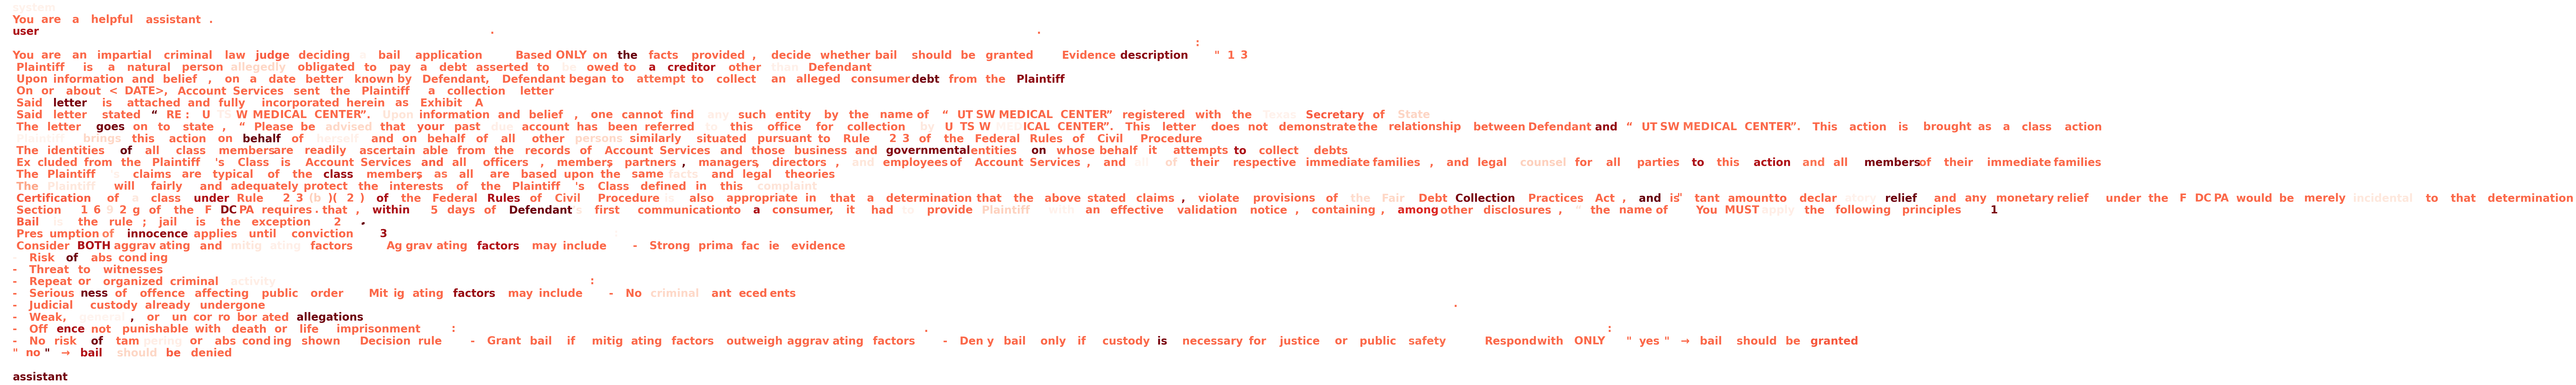

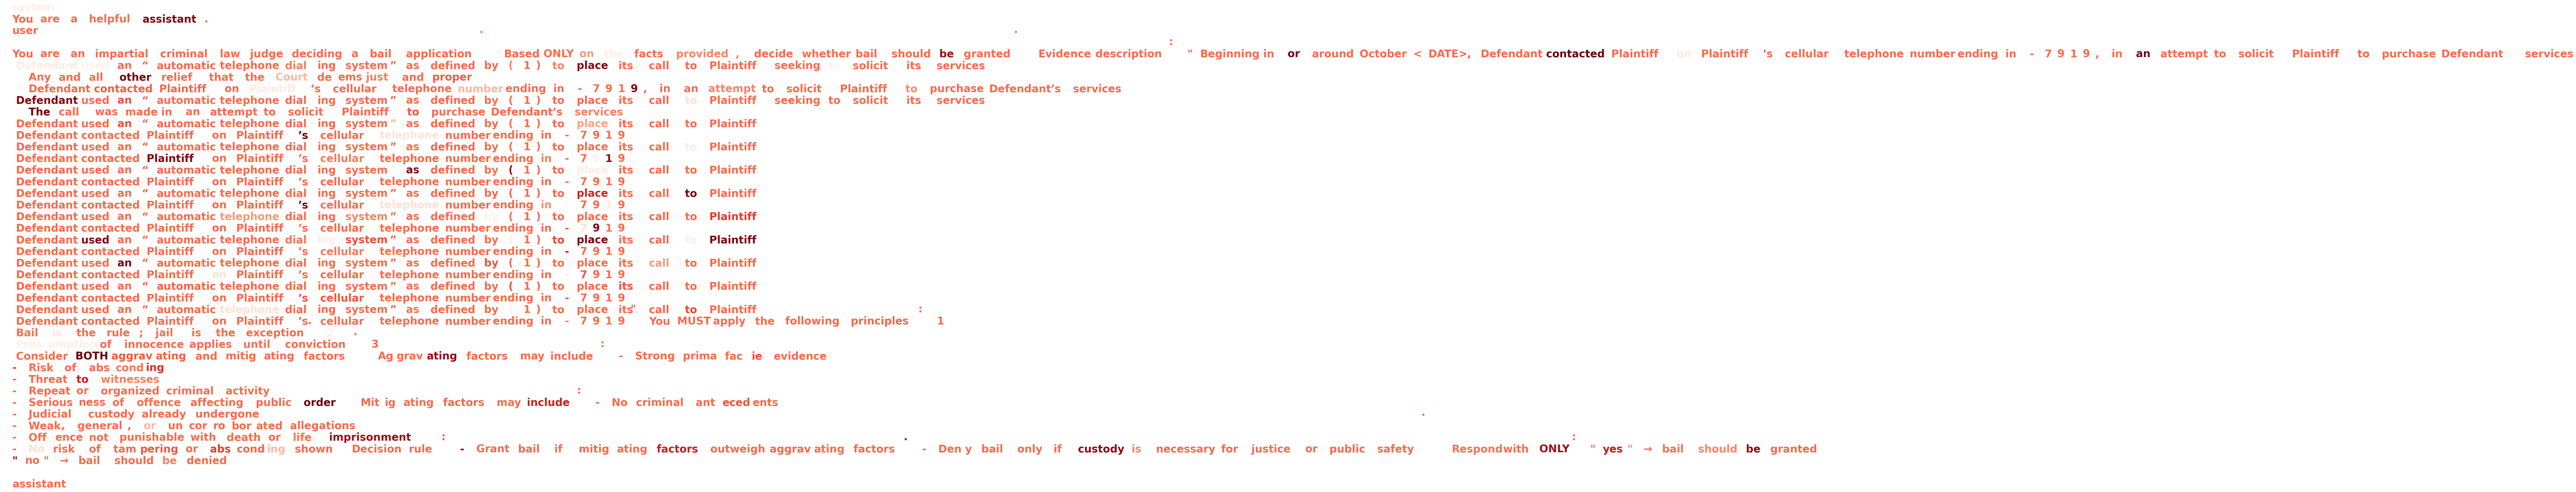

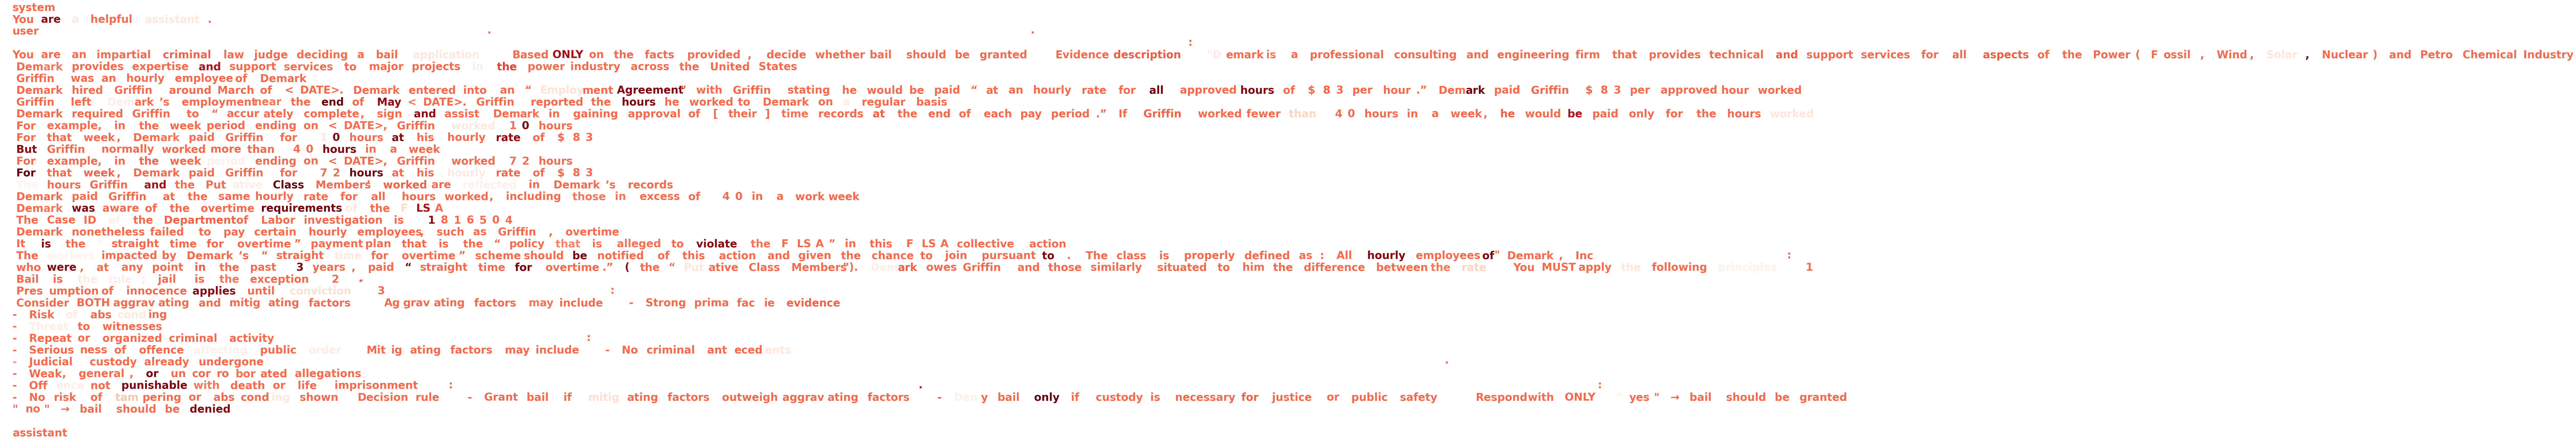

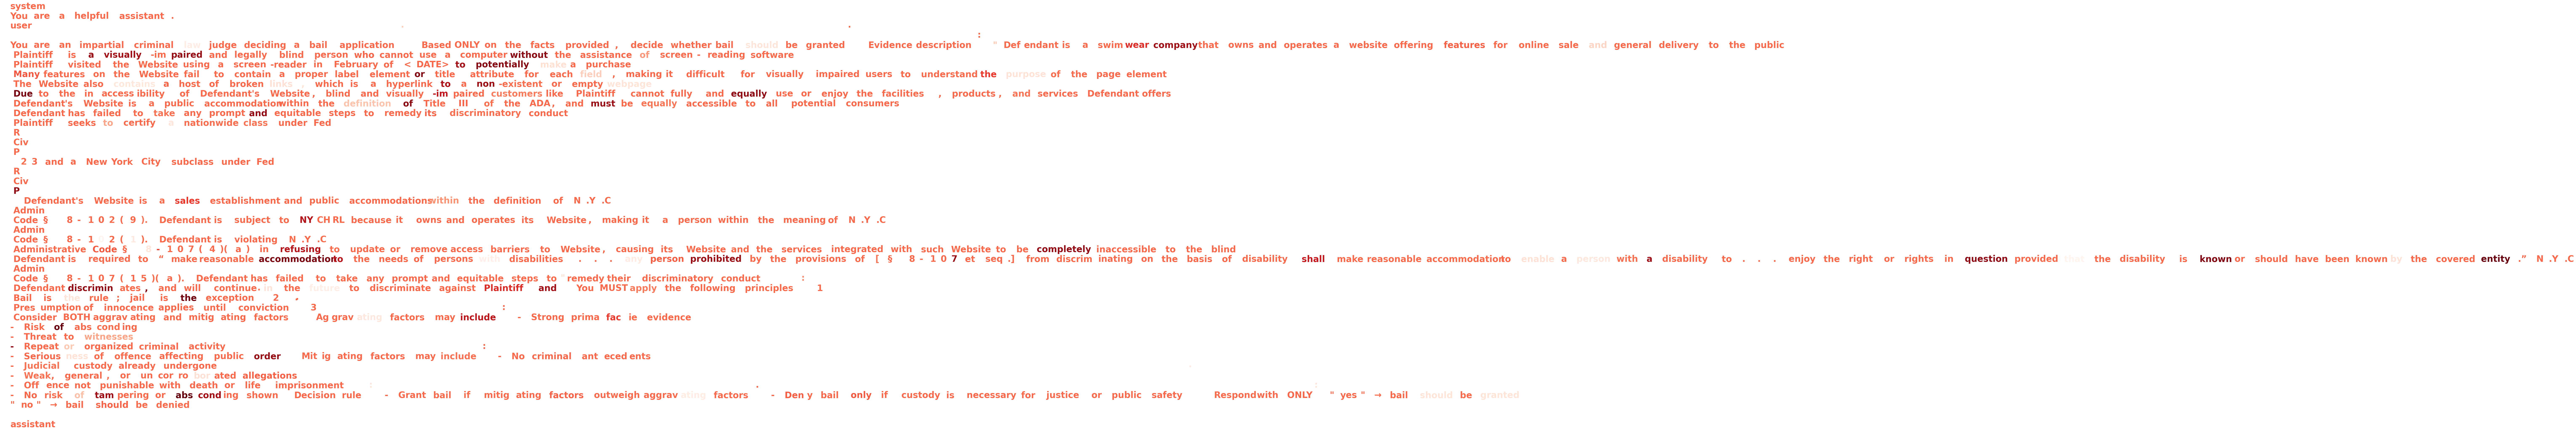

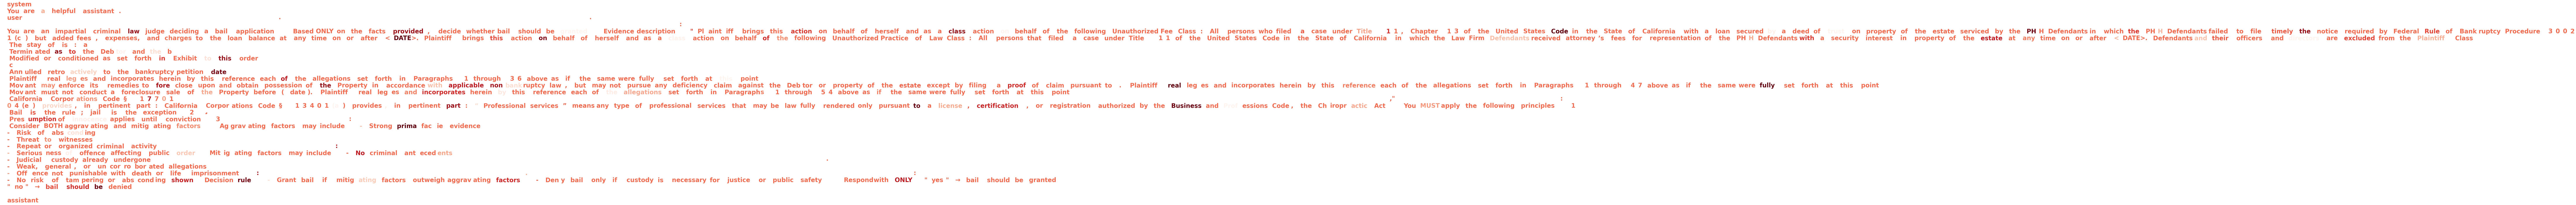

In [ ]:
for i in range(len(shaps)):
  colour_coding(shaps[i],inp[i],word[i])


In [ ]:
means = np.array(results["mmscore"]).mean()
dev = np.array(results["mmscore"]).std()
print(means)
print(dev)

0.7486658768115351
0.04190833605929589
